Game of Pong.

The Game of Pong was trained purely from image-pixels. This means is doesn't have to follow any rules/program but basically follow the A.I Model.


1) Installation of the required libraries

In [53]:
!pip install gym
!pip install numpy
# !pip install cmake

Importing libaries:


In [54]:
import gym
import numpy as np
import pickle
from matplotlib import pyplot as plt

Specific Code to download and get all ROMS automatically

In [55]:
!pip install "gym[atari,accept-rom-license]"

We then get the required ROMS(NB:used in the console for games developed)

In [56]:
!pip install unrar
!pip install mv
!pip install atari-py 

import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS   rars
!mv ROM rars
!python -m atari_py.import_roms rars

Streaming output truncated to the last 5000 lines.
Extracting  ROMS/Bank Heist (Unknown) (PAL).bin                            3%  OK 
Extracting  ROMS/Barnstorming (1982) (Activision, Steve Cartwright) (AX-013) ~.bin       3%  OK 
Extracting  ROMS/Barnstorming (CCE).bin                                    3%  OK 
Extracting  ROMS/Barnstorming (Unknown) (PAL) [a].bin                      3%  OK 
Extracting  ROMS/Barnstorming (Unknown) (PAL).bin                          3%  OK 
Extracting  ROMS/Barnstorming - Die tollkeuhnen Flieger (1982) (Activision, Steve Cartwright - Ariola) (EAX-013, PAX-013 - 711 013-720) (PAL).bin       3%  OK 
Extracting  ROMS/Base Attack (1983) (Home Vision - Gem International Corporation - VDI) (VCS83113) (PAL) ~.bin       3%  OK 
Extracting  ROMS/Base Attack (Hack) (Unknown).bin                          3%  OK 
Extracting  ROMS/Baseball (AKA Super Challenge Baseball) (1988) (Telegames) (566

In [57]:
!pip install gym >/dev/null

In [58]:
!pip install JSAnimation >/dev/null        

In [59]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

We first make a game environment and get our very first image of the game.

Environment has observation space = Box(0, 255, (210, 160, 3), uint8)


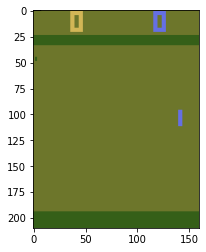

In [60]:
# env = gym.make("Pong-v0")
# frame = env.reset() # This gets us the image

env = gym.make("Pong-v0", frameskip=5)
env.seed(1); # for reproducibility
# env = gym.make("Pong-v0")# , render_mode='rgb_array'
render = lambda : plt.imshow(env.render(mode='rgb_array'))
render()
frame = env.reset() # This gets us the image

print("Environment has observation space =", env.observation_space)

Visualizing:

In [61]:
from gym import wrappers
from gym.wrappers import Monitor
     
env = wrappers.Monitor(env, 'tmp/pong-base', force=True) # record the game as as an mp4 file       

In [62]:
# Config flags - video output and res
resume = True # resume training from previous checkpoint (from save.p  file)?
render = True # render video output?

In [63]:
def display_frame(frame):
    plt.imshow(frame, cmap='Greys', interpolation='nearest')
    plt.show()
    
# print("Dimensions: {0}".format(processed_frame.shape))
# print("Size: {0}".format(processed_frame.size))

env = Monitor(env, "./video", force=True)

In [64]:
print(env.action_space)

Discrete(6)


In [65]:
print(env.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


We now have to transform the image given to us by openAI Gym into something we can work with. This is pre-processing by Cropping the image, Converting the image to black and white by removing color, removing the background and flattening.

unprocessed frame


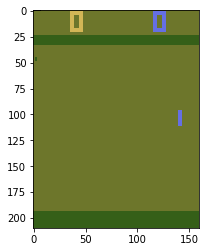

observation_frame


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


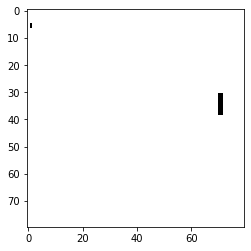

In [66]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

print("unprocessed frame")
display_frame(frame)
previously_processed_frame = None
delta_frame, previously_processed_frame = process_frame(frame, previously_processed_frame)
print("observation_frame")
display_frame(previously_processed_frame.reshape((80, 80)))

(80, 80)


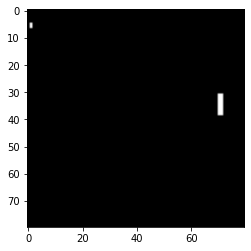

In [67]:
preprocessed_random_frame = frame_preprocessing(random_frame)
plt.imshow(preprocessed_random_frame, cmap="gray")
print(preprocessed_random_frame.shape)

Setting up parameters:
Parameters:
 H(Number of Hidden Layers): How many neurons are in our hidden layer


In [68]:
rng = np.random.default_rng(seed=12288743)
D = 80 * 80# input dimensionality: 80x80 grid
H = 200# How many neurons are in our hidden layer 
model = {}#Instantiating your policy (neural) network model as an empty dictionary. 


We then initialise the weights of the neural network.

In [69]:
model["W1"] = rng.standard_normal(size=(H, D)) / np.sqrt(D)
model["W2"] = rng.standard_normal(size=H) / np.sqrt(H)

We then apply a sigmoid function on this output value so that it’s between 0 and 1 and is therefore a valid probability (probability of going up)and apply forward and backpropagation algorithm to compute the gradient for our weights.

In [70]:
def policy_forward(x, model):
    # Matrix-multiply the weights by the input in the one and only hidden layer.
    h = np.dot(model["W1"], x)
    # Apply non-linearity with ReLU.
    h[h < 0] = 0
    # Calculate the "dot" product in the outer layer.
    # The input for the sigmoid function is called logit.
    logit = np.dot(model["W2"], h)
    # Apply the sigmoid function (non-linear activation).
    p = sigmoid(logit)
    # Return a log probability for the action 2 ("move up")
    # and the hidden "state" that you need for backpropagation.
    return p, h

In [71]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [72]:
def policy_backward(eph, epdlogp, model):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model["W2"])
    dh[eph <= 0] = 0
    dW1 = np.dot(dh.T, epx)
    # Return new "optimized" weights for the policy network.
    return {"W1": dW1, "W2": dW2}


Instantiating empty lists to store variables for each episode gained when we will be training our agent.

In [73]:
# All preprocessed observations for the episode.
xs = []
# All hidden "states" (from the network) for the episode.
hs = []
# All gradients of probability actions
# (with respect to observations) for the episode.
dlogps = []
# All rewards for the episode.
drs = []

RMSProp for optimizing the agent's policy,

In [74]:
decay_rate = 0.99 # 
gamma = 0.99

In [75]:
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}# Saving the update buffers that add up gradients over a batch

In [76]:
rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}# storing the RMSProp memory for the optimizer for gradient ascent:

We then discount our rewards such that rewards from earlier frames are discounted a lot more than rewards for later frames

In [77]:
def discount_rewards(r, gamma):
    discounted_r = np.zeros_like(r)
    running_add = 0
    # From the last reward to the first...
    for t in reversed(range(0, r.size)):
        # ...reset the reward sum
        if r[t] != 0:
            running_add = 0
        # ...compute the discounted reward
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

limiting the number of episodes for training our agent to a certain number. N/B: Can be any number depending on how you want the agent to learn. It is proper to train your agent upto 15000 episodes which takes upto 13-15 hours so to beat the computer and make it efficient but since we are interested in the output for now i put it at 3.

In [78]:
max_episodes = 3

Hyperparameters:

In [79]:
batch_size = 3
learning_rate = 1e-4

In [80]:
render = False
observation = env.reset()
prev_x = None
# 6. Initialize the reward variables and the episode count:
running_reward = None
reward_sum = 0
episode_number = 0


setting the single input frame (x) for the policy network as the difference between the current and previous preprocessed frames:

In [81]:
def update_input(prev_x, cur_x, D):
    if prev_x is not None:
        x = cur_x - prev_x
    else:
        x = np.zeros(D)
    return x

The game implemented(NB:It is trained for upto more than 10,000 episodes).The power of A.I!!

In [82]:
while episode_number < max_episodes:
    # (For rendering.)
    if render:
        env.render()

    # 1. Preprocess the observation (a game frame) and flatten with NumPy's `ravel()`.
    cur_x = frame_preprocessing(observation).ravel()

    # 2. Instantiate the observation for the policy network
    x = update_input(prev_x, cur_x, D)
    prev_x = cur_x

    # 3. Perform the forward pass through the policy network using the observations
    # (preprocessed frames as inputs) and store the action log probabilities
    # and hidden "states" (for backpropagation) during the course of each episode.
    aprob, h = policy_forward(x, model)
    # 4. Let the action indexed at `2` ("move up") be that probability
    # if it's higher than a randomly sampled value
    # or use action `3` ("move down") otherwise.
    action = 2 if rng.uniform() < aprob else 3

    # 5. Cache the observations and hidden "states" (from the network)
    # in separate variables for backpropagation.
    xs.append(x)
    hs.append(h)

    # 6. Compute the gradients of action log probabilities:
    # - If the action was to "move up" (index `2`):
    y = 1 if action == 2 else 0
    # - The cross-entropy:
    # `y*log(aprob) + (1 - y)*log(1-aprob)`
    # or `log(aprob)` if y = 1, else: `log(1 - aprob)`.
    # (Recall: you used the sigmoid function (`1/(1+np.exp(-x)`) to output
    # `aprob` action probabilities.)
    # - Then the gradient: `y - aprob`.
    # 7. Append the gradients of your action log probabilities.
    dlogps.append(y - aprob)
    # 8. Take an action and update the parameters with Gym's `step()`
    # function; obtain a new observation.
    observation, reward, done, info = env.step(action)
    # 9. Update the total sum of rewards.
    reward_sum += reward
    # 10. Append the reward for the previous action.
    drs.append(reward)

    # After an episode is finished:
    if done:
        episode_number += 1
        # 11. Collect and reshape stored values with `np.vstack()` of:
        # - Observation frames (inputs),
        epx = np.vstack(xs)
        # - hidden "states" (from the network),
        eph = np.vstack(hs)
        # - gradients of action log probabilities,
        epdlogp = np.vstack(dlogps)
        # - and received rewards for the past episode.
        epr = np.vstack(drs)

        # 12. Reset the stored variables for the new episode:
        xs = []
        hs = []
        dlogps = []
        drs = []

        # 13. Discount the rewards for the past episode using the helper
        # function you defined earlier...
        discounted_epr = discount_rewards(epr, gamma)
        # ...and normalize them because they have high variance
        # (this is explained below.)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # 14. Multiply the discounted rewards by the gradients of the action
        # log probabilities (the "advantage").
        epdlogp *= discounted_epr
        # 15. Use the gradients to perform backpropagation and gradient ascent.
        grad = policy_backward(eph, epdlogp, model)
        # 16. Save the policy gradients in a buffer.
        for k in model:
            grad_buffer[k] += grad[k]
        # 17. Use the RMSProp optimizer to perform the policy network
        # parameter (weight) update at every batch size
        # (by default: every 10 episodes).
        if episode_number % batch_size == 0:
            for k, v in model.items():
                # The gradient.
                g = grad_buffer[k]
                # Use the RMSProp discounting factor.
                rmsprop_cache[k] = (
                    decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
                )
                # Update the policy network with a learning rate
                # and the RMSProp optimizer using gradient ascent
                # (hence, there's no negative sign)
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                # Reset the gradient buffer at the end.
                grad_buffer[k] = np.zeros_like(v)

        # 18. Measure the total discounted reward.
        running_reward = (
            reward_sum
            if running_reward is None
            else running_reward * 0.99 + reward_sum * 0.01
        )
        print(
            "Resetting the Pong environment. Episode total reward: {} Running mean: {}".format(
                reward_sum, running_reward
            )
        )

        # 19. Set the agent's initial observation by calling Gym's `reset()` function
        # for the next episode and setting the reward sum back to 0.
        reward_sum = 0
        observation = env.reset()
        prev_x = None

    # 20. Display the output during training.
    if reward != 0:
        print(
            "Episode {}: Game finished. Reward: {}...".format(episode_number, reward)
            + ("" if reward == -1 else " POSITIVE REWARD!")
        )

Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Resetting the Pong environment. Episode total reward: -21.0 Running mean: -21.0
Episode 1: Game finished. Reward: -1.0...
Episode 1: Game finished. Reward: -1.0

In [83]:
# env.close()

Now, Visualising our Pong game:

We will require:

In [84]:
# Install Xvfb and X11 dependencies.
!apt-get install -y xvfb x11-utils > /dev/null 2>&1
# To work with videos, install FFmpeg.
!apt-get install -y ffmpeg > /dev/null 2>&1
# Install PyVirtualDisplay for visual feedback and other libraries/dependencies.
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate > /dev/null 2>&1

In [85]:
# Import the virtual display module.
from pyvirtualdisplay import Display
# Import ipythondisplay and HTML from IPython for image and video rendering.
from IPython import display as ipythondisplay
from IPython.display import HTML

# Initialize the virtual buffer at 400x300 (adjustable size).
# With Xvfb, you should set `visible=False`.
display = Display(visible=False, size=(400, 300))
display.start()

# Check that no display is present.
# If no displays are present, the expected output is `:0`.
!echo $DISPLAY

# Define a helper function to display videos in Jupyter notebooks:.
# (Source: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/)

import sys
import math
import glob
import io
import base64

def show_any_video(mp4video=0):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[mp4video]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                                            loop controls style="height: 400px;">
                                            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                                            </video>'''.format(encoded.decode('ascii'))))

    else:
        print('Could not find the video!')


:1


In [86]:
show_any_video(-1)

N/B: The above can be made efficient by increasing the number of episodes to train the agent really well so as to beat the computer; this can be done by changing the value of //max_episodes = 3 to a higher value, preferably 10,000. 
